<a href="https://colab.research.google.com/github/szilardnemeth/Spoon-Knife/blob/master/06b_torch_tutorial_objectdetection_SSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# —— SETUP ——
---

## Install and external

In [1]:
!pip install torchinfo

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%load_ext tensorboard

## Import

In [4]:
import time
from datetime import datetime
import csv
import json
from os.path import curdir, pardir, join, exists
import os
import copy

import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

from torch.utils.tensorboard import SummaryWriter

## wget

In [5]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

## Google Drive

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## GPU

In [7]:
if torch.cuda.is_available():
    print("GPU is available.")
    device = "cuda"
else:
    print("GPU is not available.")
    device = "cpu"


GPU is not available.


## GPU resources

In [8]:
# torch.cuda.memory_summary(device=None, abbreviated=True)
!nvidia-smi

# import gc
# del variables
# gc.collect()

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
torch.cuda.empty_cache()

In [ ]:
import sys

local_vars = locals()
local_vars_copy = copy.copy(local_vars)

# Print the variables

for var_name, var_value in local_vars_copy.items():
    # print(f"{var_name}: {var_value}, size:{sys.getsizeof(var_name)}")
    print(f"{var_name}, size:{sys.getsizeof(var_name)}")

---
# —— OD MODELS ——
---

## Read models

In [9]:
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchvision.models import VGG16_Weights

box_score_thresh = 0.2
trainable_backbone_layers = 0 # 0: last, 5:all, None: defaults to 4

kitti_categories = ['Car', 'Cyclist', 'Pedestrian', 'DontCare', 'Van', 'Tram', 'Truck', 'Misc', 'Person_sitting']
num_classes = len(kitti_categories) # Kitti categories

# model: https://github.com/pytorch/vision/blob/main/torchvision/models/detection/ssd.py
# trainable_backbone_layers: https://github.com/pytorch/vision/blob/main/torchvision/models/detection/ssd.py#L566

# weights = SSD300_VGG16_Weights.DEFAULT
# model = ssd300_vgg16(weights=weights, score_thresh=box_score_thresh, trainable_backbone_layers=trainable_backbone_layers)
# model.to(device)
# categories = weights.meta["categories"]
# model.eval()
# preprocess = weights.transforms()

#-----------
# Backbone weights only
weights_backbone = VGG16_Weights.IMAGENET1K_FEATURES
model = ssd300_vgg16(weights_backbone=weights_backbone,
                     num_classes=num_classes,
                     score_thresh=box_score_thresh,
                     trainable_backbone_layers=trainable_backbone_layers)
model_name_str = "SSD300_VGG16"
model.to(device)
model.eval()

# preprocess = weights_backbone.transforms()

Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth
100%|██████████| 528M/528M [00:07<00:00, 73.2MB/s]


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [10]:
print('='*50)
print('backbone.features')
for f in model.backbone.features:
    for parameter in f.parameters():
        print(f"\tName: {str(f)}, trainable: {parameter.requires_grad}")

# print('='*50)
# print('backbone.extra')
# print()
# for f in model.backbone.extra:
#     for parameter in f.parameters():
#         print(f"Name: {str(f)}, trainable: {parameter.requires_grad}")



backbone.features
	Name: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), trainable: False
	Name: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), trainable: False
	Name: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), trainable: False
	Name: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), trainable: False
	Name: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), trainable: False
	Name: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), trainable: False
	Name: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), trainable: False
	Name: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), trainable: False
	Name: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), trainable: False
	Name: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), trainable: False
	Name: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddi

## Model structure

In [11]:
col_names=("input_size",
                "output_size",
                "num_params",
                #"params_percent",
                # "kernel_size",
                # "mult_adds",
                "trainable"
                )

summary(model, (5, 3, 375, 1242), depth=3, col_names=col_names, verbose=0)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
SSD                                      [5, 3, 375, 1242]         [200, 4]                  --                        Partial
├─GeneralizedRCNNTransform: 1-1          [5, 3, 375, 1242]         [5, 3, 300, 300]          --                        --
├─SSDFeatureExtractorVGG: 1-2            [5, 3, 300, 300]          [5, 256, 1, 1]            512                       Partial
│    └─Sequential: 2-1                   [5, 3, 300, 300]          [5, 512, 38, 38]          --                        False
│    │    └─Conv2d: 3-1                  [5, 3, 300, 300]          [5, 64, 300, 300]         (1,792)                   False
│    │    └─ReLU: 3-2                    [5, 64, 300, 300]         [5, 64, 300, 300]         --                        --
│    │    └─Conv2d: 3-3                  [5, 64, 300, 300]         [5, 64, 300, 300]         (36,928)                  Fals

---
# —— **KITTI** ——
---



## Setup dataset and dataloader

### Custom KITTI dataset

In [90]:
from typing import Any, Callable, List, Optional, Tuple, Dict

#-------------------------------------------------------------------------------
class MyKitti(torchvision.datasets.Kitti):
    import os

    def __init__(self,
        root: str,
        train: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        transforms: Optional[Callable] = None,
        download: bool = False):

        self.__class__.__name__ = "Kitti" # torchvision.datasets.Kitti uses this to create folder structure
        self.kitti_categories = kitti_categories
        super(MyKitti, self).__init__(
            root=root,
            train=train,
            transform=transform,
            target_transform=target_transform,
            transforms=transforms,
            download=download)
    def _parse_target(self, index: int) -> List:
        target = []
        with open(self.targets[index]) as inp:
            content = csv.reader(inp, delimiter=" ")
            for line in content:
                target.append(
                    {
                        "image_id": index,
                        "image_name": os.path.split(self.images[index])[1],
                        "type": line[0],
                        "truncated": float(line[1]),
                        "occluded": int(line[2]),
                        "alpha": float(line[3]),
                        "bbox": [float(x) for x in line[4:8]],
                        "dimensions": [float(x) for x in line[8:11]],
                        "location": [float(x) for x in line[11:14]],
                        "rotation_y": float(line[14]),
                    }
                )
        return target

#-------------------------------------------------------------------------------
def target_transform(target_orig: List[Dict], categories:List[str]=None, device: str='cpu'):

    if categories is None:
        categories = kitti_categories

    map_type2label = {cat: i for i, cat in enumerate(categories)}
    target_label_categories = torch.tensor([map_type2label.get(this_object_label['type'], 0) for this_object_label in target_orig]).to(device)
    target_label_bbox = [torch.tensor(this_object_label['bbox']).unsqueeze(0).to(device) for this_object_label in target_orig]
    target_label_bbox = torch.cat(target_label_bbox, dim=0)
    num_objs = len(target_label_categories)
    target_transformed = {'boxes': target_label_bbox,
                          'labels': target_label_categories,
                          'iscrowd': torch.zeros((num_objs, ), dtype=torch.int64), # needed for COCO eval
                          'area': (target_label_bbox[:, 2]-target_label_bbox[:, 0]) * (target_label_bbox[:, 3]-target_label_bbox[:, 1])} # needed for COCO eval
    return target_transformed

In [93]:
if not os.path.isdir("/content/drive/MyDrive/data/Kitti"):
    is_download = True
    print(f"Downloading Kitti...")
else:
    is_download = False
    print(f"Kitti is already downloaded.")

transform = transforms.Compose([
    transforms.ToTensor(), # ToTensor converts to float [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


t0 = time.time()
kitti_set = MyKitti(root='/content/drive/MyDrive/data',train=True, download=is_download, transform=transform, target_transform=lambda x: target_transform(x, categories=kitti_categories, device=device))
kitti_set_untransformed = MyKitti(root='/content/drive/MyDrive/data',train=True, download=is_download, transform=transforms.ToTensor())

indices = list(range(len(kitti_set)))
training_set = torch.utils.data.Subset(kitti_set, indices[:128])
validation_set = torch.utils.data.Subset(kitti_set, indices[128:(128+64)])

# images = validation_set.dataset.images
# indices = validation_set.indices
# imagenames_validation = [os.path.split(images[this_ind])[1] for this_ind in indices]

print(f"Done. Elspased time: {time.time()-t0: 0.2f}sec")
print(f"Train set: {len(training_set)}, val set: {len(validation_set)}")

Kitti is already downloaded.
Done. Elspased time:  0.26sec
Train set: 128, val set: 64


In [92]:
target_transform(kitti_set_untransformed[0][1])

{'boxes': tensor([[   0.0000,  200.1100,  302.9300,  369.0000],
         [ 991.5800,  147.0800, 1029.4301,  216.6600],
         [1047.5800,  144.2700, 1095.5900,  247.8600],
         [1071.4700,  148.5900, 1122.8300,  251.3400],
         [ 482.0000,  170.4200,  580.4900,  211.6300],
         [ 638.7400,  167.5400,  648.0200,  177.8500],
         [ 660.3200,  166.5100,  668.5700,  174.7600],
         [ 879.2400,  156.2400,  907.0200,  195.3200]]),
 'labels': tensor([0, 1, 2, 2, 0, 3, 3, 3]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0]),
 'area': tensor([51161.8477,  2633.6057,  4973.3569,  5277.2383,  4058.7732,    95.6772,
            68.0625,  1085.6436])}

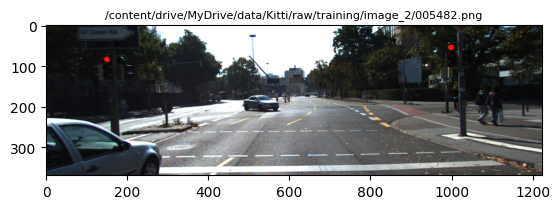

In [95]:
n_image = 0
plt.imshow(kitti_set_untransformed[n_image][0].permute([1, 2, 0]))
_ = plt.title(kitti_set_untransformed.images[0], fontsize=8)

## DataLoader

In [54]:
batch_size = 64
shuffle = True

def collate_fn(batch):
    # Batch in Kitti looks like this:
    # batch = [('t0', ['o0_0', 'o0_1', 'o0_2']), ('t1', ['o1_0', 'o1_1'])]
    # where
    # 't0': tensor of the first image with shape(3, H, W)
    # 'oi_j': dict, the jth object of the ith image
    # collate_fn returns: (('t0', 't1'), (['o0_0', 'o0_1', 'o0_2'], ['o1_0', 'o1_1']))
    return tuple(zip(*batch))

training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
validation_loader_fortesting = torch.utils.data.DataLoader(validation_set, batch_size=2, shuffle=False, collate_fn=collate_fn)

----
# **—— PREPARATION & SOME TESTING ——**
----


## Get some data (one batch) and move to GPU

In [49]:
images_list, target_list = next(iter(validation_loader_fortesting)) # `images_list` is a list of length=batch_size

# Move element to GPU
images_list = [img.to(device) for img in images_list]

#------------------------
# Create a 4D tensor and move element to GPU.
# 1) NOTE: resize is needed as Kitti images are not the same size
# 2) NOTE: this yileds a slightly different results.
# 3) bboxes are to be transformed, too. tv_tensor is the way

# resize = transforms.Resize((375, 1242)) # Kitti images are not of the same size
# images_tensor = torch.cat([resize(tensor).unsqueeze(0).to(device) for tensor in images_list], dim=0) # images_tensor is a tensor with first dimension=batch_size

## Loss: prediction on both input and target

In [14]:
model.train()

t0 = time.time()
out = model(images_list, target_list) # `images_list`: list of 3D tensor, `target`: list
print(f"Pred: {time.time()-t0: 0.4f} sec")
print(f"Num of images: {len(images_list)}, num of target labels: {len(target_list)}")
print(out)

loss = out['bbox_regression'] + out['classification']
print(loss)

Pred:  2.5259 sec
Num of images: 2, num of target labels: 2
{'bbox_regression': tensor(48.2752, grad_fn=<DivBackward0>), 'classification': tensor(75.2280, grad_fn=<DivBackward0>)}
tensor(123.5032, grad_fn=<AddBackward0>)


## One step at a time

In [15]:
learning_rate = 1e-4
optim_sgd = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [17]:
model.train()

out = model(images_list, target_list) # `images_list`: list of 3D tensor, `target`: list
print(out)

loss = out['bbox_regression'] + out['classification']
loss.backward()
optim_sgd.step()
optim_sgd.zero_grad()
model.eval()
pred = model(images_list)
labels = pred[0]['labels'].to('cpu').numpy()
print(f"Num of detections: {len(labels)}")
print(pd.Series(labels).value_counts().sort_index())

{'bbox_regression': tensor(105.2563, grad_fn=<DivBackward0>), 'classification': tensor(56.0759, grad_fn=<DivBackward0>)}
Num of detections: 200
1    36
2    15
3    71
4    32
5    16
6    10
7    15
8     5
dtype: int64


---
# ——**TRAIN**——
---

## Optimizer

In [80]:
learning_rate = 0.001
optim_sgd = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Train one epoch

In [19]:
def train_one_epoch(training_loader, model, optim_sgd):
    num_of_batches = len(training_loader)
    num_of_images = len(training_loader.dataset)
    t0 = time.time()
    batch_loss = []
    for i_batch, (images_list, target_list) in enumerate(training_loader):
        print(f'\tBatch: {i_batch}/{num_of_batches-1}')

        model.train()
        images_list = [img.to(device) for img in images_list]

        # print('Forward...')
        out = model(images_list, target_list) # `images_list`: list of 3D tensor, `target`: list
        # print(f'\b, {time.time()-t0:0.2f}s')

        loss = out['bbox_regression'] + out['classification']
        print(f'\b, loss (train): {loss: 0.4f}')

        # print('Backward...')
        loss.backward()
        # print(f'\b, {time.time()-t0:0.2f}s')
        optim_sgd.step()
        optim_sgd.zero_grad()

        batch_loss.append(loss.item())

    torch.cuda.empty_cache()
    # print(f'Total time: {time.time()-t0:0.2f}s')
    # print(f'Loss (train): {loss: 0.8f}')
    return np.array(batch_loss).mean()

def validate_one_epoch(data_loader, model):
    num_of_batches = len(data_loader)
    num_of_images = len(data_loader.dataset)
    t0 = time.time()
    batch_loss = []
    for i_batch, (images_list, target_list) in enumerate(data_loader):
        # print(f'\tBatch: {i_batch}/{num_of_batches-1}')

        model.train()
        images_list = [img.to(device) for img in images_list]

        # print('Forward...')
        out = model(images_list, target_list) # `images_list`: list of 3D tensor, `target`: list
        # print(f'\b, {time.time()-t0:0.2f}s')

        loss = out['bbox_regression'] + out['classification']
        # print(f'\b, Loss (validation): {loss: 0.4f}')

        batch_loss.append(loss.item())
    return np.array(batch_loss).mean()

train_loss = train_one_epoch(training_loader, model, optim_sgd)
validation_loss = validate_one_epoch(validation_loader, model)

print(f"Train loss: {train_loss}")
print(f"Validation loss: {validation_loss}")

	Batch: 0/1


KeyboardInterrupt: ignored

## Train

In [82]:
num_epoch = 10

t0 = time.time()
for i_epoch in range(num_epoch):
    print(f"Epoch: {i_epoch} / num_epoch")
    print("Train")
    train_loss = train_one_epoch(training_loader, model, optim_sgd)
    print(f"\tTrain loss: {train_loss}")
    print("Validation")
    validation_loss = validate_one_epoch(validation_loader, model)
    print(f"\bValidation loss: {validation_loss}")
    print(f'Elapsed time: {time.time()-t0:0.2f}s')

print(f'Elapsed time: {time.time()-t0:0.2f}s')

Epoch: 0 / num_epoch
Train
Batch: 0/1
, Loss (train):  381.7196
, 2.47s
Batch: 1/1
, Loss (train):  123.6922
, 5.15s
Train loss: 252.70587921142578
Validation
Batch: 0/0
, Loss (validation):  117.0520
Validation loss: 117.05203247070312
Elapsed time: 8.07s
Epoch: 1 / num_epoch
Train
Batch: 0/1
, Loss (train):  137.2814
, 2.54s
Batch: 1/1
, Loss (train):  49.8247
, 5.07s
Train loss: 93.55305671691895
Validation
Batch: 0/0
, Loss (validation):  33.5530
Validation loss: 33.55303192138672
Elapsed time: 15.68s
Epoch: 2 / num_epoch
Train
Batch: 0/1
, Loss (train):  30.6341
, 2.33s
Batch: 1/1
, Loss (train):  34.5102
, 5.06s
Train loss: 32.57216835021973
Validation
Batch: 0/0
, Loss (validation):  26.4197
Validation loss: 26.41970443725586
Elapsed time: 23.72s
Epoch: 3 / num_epoch
Train
Batch: 0/1
, Loss (train):  27.3872
, 2.31s
Batch: 1/1
, Loss (train):  20.7136
, 4.79s
Train loss: 24.050439834594727
Validation
Batch: 0/0
, Loss (validation):  23.8545

## Evaluate

In [ ]:
torch.zeros((5,), dtype=torch.int64)

In [55]:
from engine import train_one_epoch, evaluate
evaluate(model, validation_loader, device=device)

creating index...
index created!
Test:  [0/1]  eta: 0:02:08  model_time: 100.6620 (100.6620)  evaluator_time: 25.5332 (25.5332)  time: 128.5537  data: 2.3582
Test: Total time: 0:02:08 (128.5764 s / it)
Averaged stats: model_time: 100.6620 (100.6620)  evaluator_time: 25.5332 (25.5332)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Aver

---
# —— **PLAYGROUND** ——
---

In [ ]:
model.box_coder

(10.0, 10.0, 5.0, 5.0)

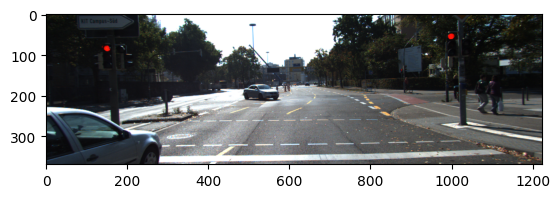

In [ ]:
plt.imshow(images_list[0].transpose(0,2).transpose(1,0).detach().cpu().numpy())

In [ ]:
import torch

# Example of target with class indices
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
loss = torch.nn.CrossEntropyLoss(reduction='mean')
# input = torch.randn(3, 5)
input = 1*torch.tensor([[0, 1, 0, 0, 0],[0, 0, 1, 0, 0],[0, 0, 0, 1, 0]], dtype=torch.float, requires_grad=True)
# input = input.softmax(dim=1)
print(input)
target = torch.tensor([1, 2, 3])
output = loss(input, target)
print(target)
print(output)
output.backward()
print(output)

tensor([[0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.]], grad_fn=<MulBackward0>)
tensor([1, 2, 3])
tensor(0.9048, grad_fn=<NllLossBackward0>)
tensor(0.9048, grad_fn=<NllLossBackward0>)
